## Setup

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from copy import deepcopy

from sklearn import feature_selection, svm, preprocessing, model_selection, ensemble
from sklearn import neighbors
from sklearn.pipeline import Pipeline

import xgboost
import shap

from nilearn import datasets as nilean_datasets

import matplotlib.pyplot as plt
import seaborn as sns; sns.set('paper')
import plotly.express as px
from tqdm import tqdm

shap.initjs()

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Last updated: 2022-02-19T14:08:56.993345+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

xarray    : 0.21.1
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
sklearn   : 1.0.2
numpy     : 1.21.5
matplotlib: 3.5.1
seaborn   : 0.11.2
xgboost   : 1.5.1
pandas    : 1.4.0
plotly    : 5.5.0
shap      : 0.40.0
nilearn   : 0.9.0



In [2]:
# parameters

TRIU_K = 0
DATASET_NAME = 'dosenbach2010_tangent'

## Data

In [3]:
atlases = ['dosenbach2007', 'dosenbach2010', 'difumo_64_2',]# 'difumo_128_2',]# 'difumo_1024_2']

connectivity_measures = ['tangent', 'precision', 'correlation',
                         'covariance', 'partial_correlation']

DATASETS = dict()

for atlas in atlases:
  for connectivity in connectivity_measures:
    _conn_key = f'{connectivity}_connectivity'
    ds = xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')
    _conn = ds[_conn_key]
    _conn.coords['group'] = ds.group
    _conn['inverse_efficiency_score_ms'] = ds['inverse_efficiency_score_ms']
    DATASETS[f'{atlas}_{connectivity}'] = _conn
    
    if 'difumo_names' in ds.coords:
      _conn.coords['region'] = ds.coords['difumo_names'].values


In [4]:
dataset = DATASETS[DATASET_NAME]

behavioral_scores = dataset['inverse_efficiency_score_ms'].values

# remove subjects with missing behavioral data or duplicate scanning sessions
# subject_labels = xr.concat([dataset['subject'], dataset['subject'] + 'NEW'], dim='subject')
# invalid_subjects = subject_labels.to_series().duplicated(keep='first')[32:]
# invalid_subjects = invalid_subjects | np.isnan(behavioral_scores)
invalid_subjects = np.isnan(behavioral_scores)

In [5]:
regions = dataset.coords['region'].values

feature_names = pd.DataFrame(
  np.empty((len(regions), len(regions))),
  index=regions, columns=regions)

feature_names = feature_names.apply(lambda x: x.index + ' \N{left right arrow} ' + x.name)
feature_names = feature_names.values[np.triu_indices_from(feature_names.values, k=TRIU_K)]

# X
X = np.array([subj_conn[np.triu_indices_from(subj_conn, k=TRIU_K)]
              for subj_conn in dataset.values])

X_threshold = np.median(X, axis=1) + np.std(X, axis=1)
X = np.where(np.abs(X) >= X_threshold.reshape(-1,1), X, 0)

# y
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(dataset['group'])

# remove subjects with missing behavioral data
X = X[~invalid_subjects]
y = y[~invalid_subjects]

## Model

In [6]:

# ALT 1: SVM
model = Pipeline([
    ('zerovar', feature_selection.VarianceThreshold(.01)),
    ('model', svm.SVC(kernel='rbf', C=1, probability=True)),
], verbose=False)

# ALT2: RandomForest
model = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)

# ALT3: XGBoost
model = xgboost.XGBClassifier(
    n_estimators=100, max_depth=10,
    use_label_encoder=False,
    eval_metric='auc',
    n_jobs=-1)

# TODO hyper-parameter tuning

train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.5,
  shuffle=True,
  stratify=y,
)

model.fit(X[train], y[train])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [7]:
%%script echo skipping...

# DEBUG /start

test_score = model_selection.cross_val_score(
    model, X, y, n_jobs=-1, scoring='roc_auc',
    cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=20),
)

print(f'mean(CV-AUC): {test_score.mean():.2f}')

perm_score, _, pvalue = model_selection.permutation_test_score(
    model, X, y,
    cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10),
    n_jobs=-1,
    n_permutations=10,
    # cv=5,
    scoring='roc_auc')

print(f'Permutation test AUC: {perm_score:.2f} (p-value={pvalue:.3f})')

# DEBUG /end

skipping...


## CV-SHAP

In [8]:
shap_values_cv = []
X_test_indices_cv = []
y_test_cv = []
y_pred_cv = []
expected_value_cv = []

cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=200)

n_splits = cv.get_n_splits(X, y)

for train, test in tqdm(cv.split(X, y), total=n_splits):

    # train the model
    model.fit(X[train], y[train])
    y_pred = model.predict(X[test])
    
    # # fit explainer
    explainer = shap.Explainer(
        model, X[train],
        feature_names=feature_names,
        algorithm='tree',
        # output_names=dataset['group'].values[train],
        # feature_perturbation='tree_path_dependent'
    )

    # evaluate explainer
    # Note: for Permutation explainer, add max_evals= 100 * X.shape[1] + 1
    shap_values = explainer(X[test])
    # shap_interaction_values = explainer.shap_interaction_values(X[test])

    shap_values_cv.append(shap_values)
    expected_value_cv.append(explainer.expected_value)
    X_test_indices_cv.append(test)
    y_test_cv.append(y[test])
    y_pred_cv.append(y_pred)

# merge CV results
X_test = pd.DataFrame(X[np.hstack(X_test_indices_cv)], columns=feature_names)
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]


In [74]:

shap_values = shap.Explanation(
  values = np.vstack([sh.values for sh in shap_values_cv]),
  base_values = np.hstack([sh.base_values for sh in shap_values_cv]),
  data = np.vstack([sh.data for sh in shap_values_cv]),
  feature_names=shap_values_cv[0].feature_names,
  compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
  output_names=y_encoder.classes_,
  output_indexes=y_pred,
)

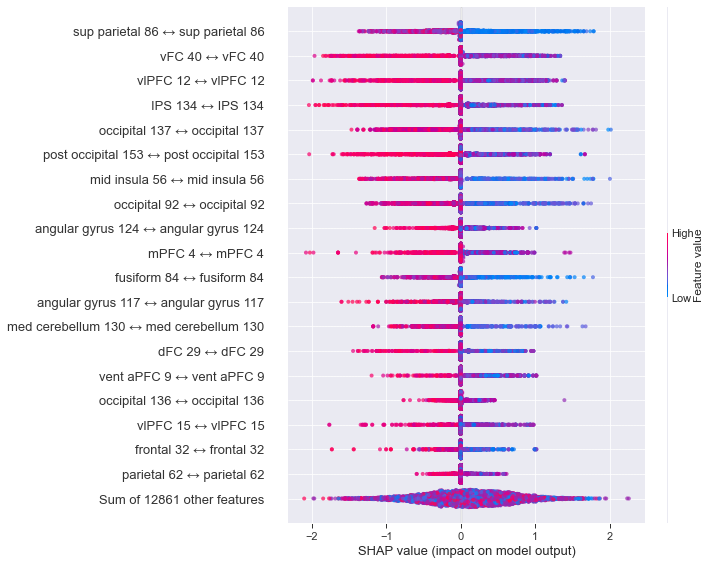

In [75]:
# WORKAROUND: there is a bug in summary plots that changes the ordering of the SHAPs.
#             We deep-copy the shap_values before plotting to keep the original intact.

shap.plots.beeswarm(deepcopy(shap_values), max_display=20, alpha=.7)


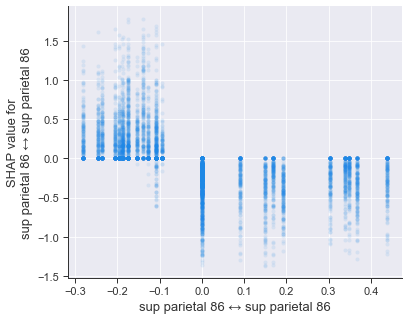

In [84]:
shap.dependence_plot(
  'rank(0)',
  shap_values.values.copy(),
  X_test,
  feature_names=feature_names,
  alpha=.1,
  interaction_index=None,
  # interaction_index='rank(1)'
)


In [12]:
# TODO subsample to speed up plotting
# shap.force_plot(np.mean(expected_values_cv), shap_values, X_test, feature_names=feature_names)

[1830 2899  253 4006 2172 4141 3727 3135 1163 1637]


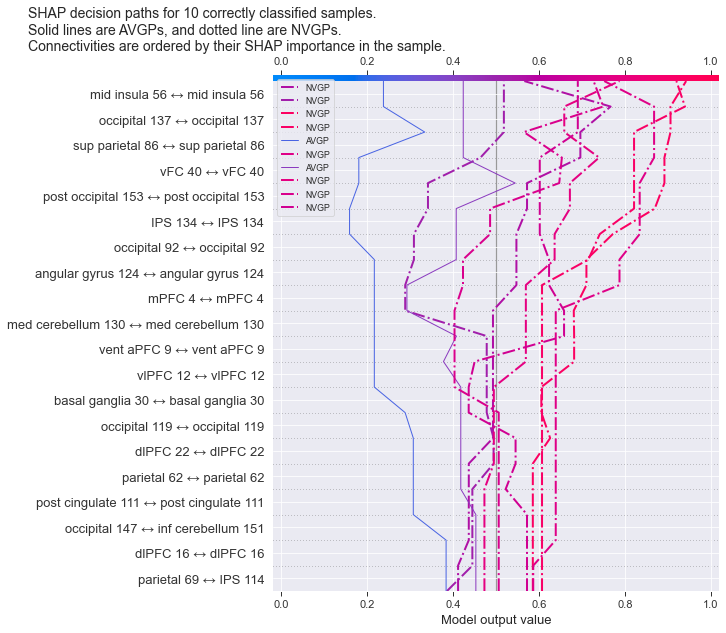

In [276]:
n_samples = 10
select_mask = np.where(y_pred == y_test)[0]     # correctly classified
# select_mask = np.where(y_pred != y_test)[0]   # misclassified
# select_mask = np.where(y_pred)[0]             # predicted class
# select_mask = np.where(y_test)[0]             # true class


select_mask = shap.utils.sample(select_mask, n_samples, random_state=None)

print(select_mask)
highlight_mask = (y_test[select_mask] == 1)

def legend_labels(idx):
  return [y_encoder.classes_[i] for i in idx.astype(int)]

shap.plots.decision(np.mean(expected_value_cv),
                    shap_values.values[select_mask],
                    link='logit',
                    # feature_order='hclust',
                    # highlight=misclassified,
                    # ignore_warnings=True,
                    legend_labels=legend_labels(highlight_mask),
                    highlight=highlight_mask,
                    show=False,
                    feature_names = feature_names.tolist())

plt.suptitle(f'SHAP decision paths for {n_samples} correctly classified samples.\n'
             'Solid lines are AVGPs, and dotted line are NVGPs.\n'
             'Connectivities are ordered by their SHAP importance in the sample.',
             ha='left', x=-.3, fontsize=14)
plt.show()

In [278]:
def get_network_name(region, dataset_name=None):

  if 'difumo' in dataset_name.lower():
    atlas = nilean_datasets.fetch_atlas_difumo(
      dimension=64, resolution_mm=2, legacy_format=False)

    labels = atlas.labels.set_index('difumo_names')
    
    return labels.loc[region,'yeo_networks17']
  
  elif 'dosenbach2010' in dataset_name.lower():
    atlas = nilean_datasets.fetch_coords_dosenbach_2010(legacy_format=False)
    labels = pd.concat(
      [pd.DataFrame(v) for k, v in atlas.items() if k != 'description'], axis=1)
    labels.set_index(0, inplace=True)
    
    return labels.loc[region,'network']

  raise Exception('Invalid atlas name.')

In [279]:

shap2d_size = len(dataset.coords['region'])

agg_shap_values = np.abs(shap_values.values).sum(axis=0)


shap2d_values = np.zeros((shap2d_size, shap2d_size))
shap2d_triu_indices = np.triu_indices(shap2d_size, k=TRIU_K)
shap2d_values[shap2d_triu_indices] = agg_shap_values
shap2d_values = shap2d_values + shap2d_values.T - np.diag(np.diag(shap2d_values))

shap2d = pd.DataFrame(shap2d_values,
                      index=dataset.coords['region'],
                      columns=dataset.coords['region'])


sorted_shap_indices = np.argsort(agg_shap_values)[::-1]
top_n = 10
triu_idx = sorted_shap_indices[:top_n]
row_idx = np.triu_indices(shap2d_size, k=TRIU_K)[0][triu_idx]
col_idx = np.triu_indices(shap2d_size, k=TRIU_K)[1][triu_idx]

# DEBUG make sure indices are mapped correctly
assert np.all(shap2d_values[row_idx,col_idx] == agg_shap_values[triu_idx])


print('Top contributing connectivities:')
for i, (row, col) in enumerate(zip(row_idx, col_idx)):
  # print(f'{shap2d.index[i]} - {shap2d.columns[j]}')
  row_region = dataset.coords['region'].values[row]
  col_region = dataset.coords['region'].values[col]
  row_net = get_network_name(row_region, DATASET_NAME)
  col_net = get_network_name(col_region, DATASET_NAME)  
  print(f'{i+1}) {row_region} \N{left right arrow} {col_region} '
        f'[{row_net} \N{left right arrow} {col_net}]')
  
# Top contributing connectivities:
# 1) sup parietal 86 ↔ sup parietal 86 [occipital ↔ occipital]
# 2) vFC 40 ↔ vFC 40 [cingulo-opercular ↔ cingulo-opercular]
# 3) vlPFC 12 ↔ vlPFC 12 [default ↔ default]
# 4) IPS 134 ↔ IPS 134 [sensorimotor ↔ sensorimotor]
# 5) occipital 92 ↔ occipital 92 [sensorimotor ↔ sensorimotor]
# 6) post occipital 153 ↔ post occipital 153 [default ↔ default]
# 7) mid insula 56 ↔ mid insula 56 [occipital ↔ occipital]
# 8) occipital 137 ↔ occipital 137 [sensorimotor ↔ sensorimotor]
# 9) angular gyrus 124 ↔ angular gyrus 124 [sensorimotor ↔ sensorimotor]
# 10) mPFC 4 ↔ mPFC 4 [sensorimotor ↔ sensorimotor]

# Top contributing connectivities:
# 1) sup parietal 86 ↔ sup parietal 86 [occipital ↔ occipital]
# 2) vFC 40 ↔ vFC 40 [cingulo-opercular ↔ cingulo-opercular]
# 3) IPS 134 ↔ IPS 134 [sensorimotor ↔ sensorimotor]
# 4) vlPFC 12 ↔ vlPFC 12 [default ↔ default]
# 5) occipital 137 ↔ occipital 137 [sensorimotor ↔ sensorimotor]
# 6) post occipital 153 ↔ post occipital 153 [default ↔ default]
# 7) mid insula 56 ↔ mid insula 56 [occipital ↔ occipital]
# 8) occipital 92 ↔ occipital 92 [sensorimotor ↔ sensorimotor]
# 9) angular gyrus 124 ↔ angular gyrus 124 [sensorimotor ↔ sensorimotor]
# 10) mPFC 4 ↔ mPFC 4 [sensorimotor ↔ sensorimotor]

# Top contributing connectivities:
# 1) sup parietal 86 ↔ sup parietal 86 [occipital ↔ occipital]
# 2) vFC 40 ↔ vFC 40 [cingulo-opercular ↔ cingulo-opercular]
# 3) vlPFC 12 ↔ vlPFC 12 [default ↔ default]
# 4) IPS 134 ↔ IPS 134 [sensorimotor ↔ sensorimotor]
# 5) occipital 137 ↔ occipital 137 [sensorimotor ↔ sensorimotor]
# 6) post occipital 153 ↔ post occipital 153 [default ↔ default]
# 7) mid insula 56 ↔ mid insula 56 [occipital ↔ occipital]
# 8) occipital 92 ↔ occipital 92 [sensorimotor ↔ sensorimotor]
# 9) angular gyrus 124 ↔ angular gyrus 124 [sensorimotor ↔ sensorimotor]
# 10) mPFC 4 ↔ mPFC 4 [sensorimotor ↔ sensorimotor]

Top contributing connectivities:
1) sup parietal 86 ↔ sup parietal 86 [occipital ↔ occipital]
2) vFC 40 ↔ vFC 40 [cingulo-opercular ↔ cingulo-opercular]
3) vlPFC 12 ↔ vlPFC 12 [default ↔ default]
4) IPS 134 ↔ IPS 134 [sensorimotor ↔ sensorimotor]
5) occipital 137 ↔ occipital 137 [sensorimotor ↔ sensorimotor]
6) post occipital 153 ↔ post occipital 153 [default ↔ default]
7) mid insula 56 ↔ mid insula 56 [occipital ↔ occipital]
8) occipital 92 ↔ occipital 92 [sensorimotor ↔ sensorimotor]
9) angular gyrus 124 ↔ angular gyrus 124 [sensorimotor ↔ sensorimotor]
10) mPFC 4 ↔ mPFC 4 [sensorimotor ↔ sensorimotor]


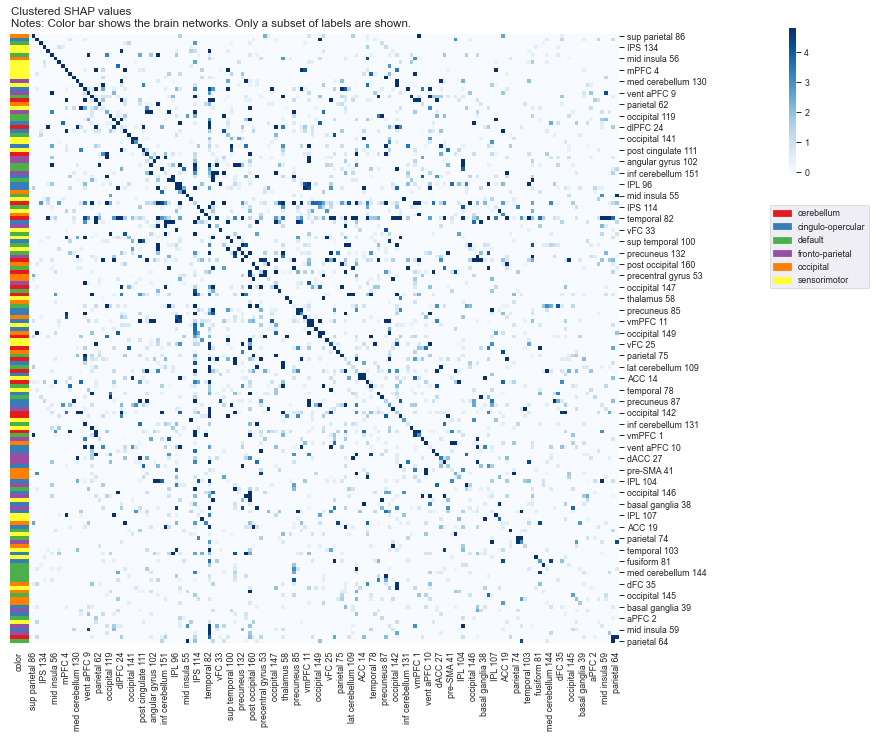

In [280]:
network_names = shap2d.index.to_frame(name='network').apply(
  lambda x: get_network_name(x, DATASET_NAME)
  )

palt = dict(zip(network_names['network'].unique(),
                sns.color_palette('Set1', network_names.nunique()['network'])))

row_colors = network_names.apply(
  lambda x: pd.Series((palt[x['network']], x['network'])), axis=1)
row_colors.rename(columns={0:'color', 1:'network'}, inplace=True)
row_colors.index.name = 'region'

import matplotlib.patches as mpatches

row_colors_legend = [mpatches.Patch(color=c, label=n)
                     for l,c,n in row_colors.drop_duplicates('network').itertuples()]

g = sns.clustermap(
  shap2d,
  figsize=(10,10),
  row_colors=row_colors[['color']],
  robust=True,
  dendrogram_ratio=0.0001,
  cbar_pos=(1.1, .79, 0.01, 0.2),
  cmap='Blues')

legend2=g.ax_heatmap.legend(
  loc='center left',
  bbox_to_anchor=(1.25,0.65),
  handles=row_colors_legend,
  frameon=True)

plt.suptitle('Clustered SHAP values\n'
             'Notes: Color bar shows the brain networks. '
             'Only a subset of labels are shown.', x=0.02, y=1.02, ha='left')

plt.show()

## interactive heatmap (but not clustered)
# fig = px.imshow(shap2d, aspect='auto', height=800)
# fig.show()

In [281]:

from nilearn import plotting

if 'dosenbach2010' in DATASET_NAME:
  atlas = nilean_datasets.fetch_coords_dosenbach_2010(legacy_format=False)
  atlas_coordinates = atlas['rois'].values
elif 'difumo' in DATASET_NAME:
  atlas = nilean_datasets.fetch_atlas_difumo(64, 2, legacy_format=False)
  atlas_coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas.maps)
  labels = atlas.labels.set_index('difumo_names')

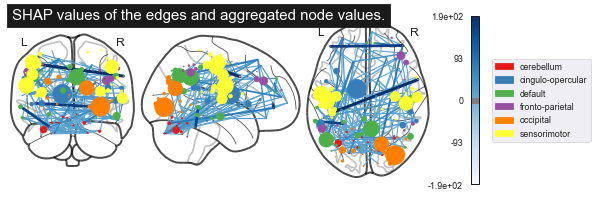

In [306]:
# METHOD 1: nodes are sized by their self-loop (diagonals in the adjacency matrix)
node_strength = np.diag(shap2d) / 5

plotting.plot_connectome(
  shap2d, atlas_coordinates,
  node_color=row_colors['color'],
  colorbar=True,
  node_size=node_strength,
  edge_cmap='Blues',
  title='SHAP values of the edges and aggregated node values.',
  edge_threshold='99%')

plt.gca().legend(
  loc='center left',
  bbox_to_anchor=(2,0.5),
  handles=row_colors_legend,
  frameon=True)

plt.show()

invalid value encountered in sqrt


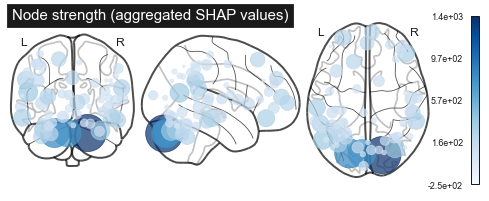

In [308]:
# METHOD 2: nodes are sized by the sum of their edge weights to all other nodes

node_strength = np.sum(shap2d.values, axis=1).reshape(-1, 1)
node_strength = preprocessing.StandardScaler().fit_transform(shap2d.values)
node_strength = node_strength.sum(axis=1) * 10

plotting.plot_markers(
    node_strength,
    atlas_coordinates,
    node_size=node_strength,
    title='Node strength (aggregated SHAP values)',
    node_cmap='Blues'
)

plt.show()

In [310]:
view = plotting.view_connectome(
    shap2d.values, atlas_coordinates,
    node_color=row_colors['color'],
    node_size=np.diag(shap2d)/50, edge_threshold=10,
    colorbar_fontsize=12,
    title=f'SHAP values ({DATASET_NAME})')

view